# 0. Preparation

## (Optoinal) mount google drive
- Make sure that available access is the user's own drive(no access across files in shared folder)

In [1]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Import libraries

In [ ]:
if IN_COLLAB:
  !pip install torch pytorch-lightning pytorch_forecasting azure-storage-blob

In [3]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn as nn
import pytorch_lightning as pl

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.environ["MY_HOME_ABS_PATH"] = MY_HOME_ABS_PATH
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

# Load data from Azure blob

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"
local_file = tmp_dir + os.sep + blob_name

In [5]:
# Download full data
root_dir  = MY_HOME_ABS_PATH
tmp_dir   = root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'

container = "all-sites-data"
blob_name = "hybrid-2010-2015-raw-v0.parquet"
local_file = tmp_dir + os.sep + blob_name

data_df = get_raw_datasets(container, blob_name)
data_df.rename(columns={"rfr_pred_gpp": "estimated_gpp"}, inplace=True)

Data size: (4862712, 52)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month', 'rfr_pred_gpp'],
      dtype='object')
NA count: 0


# Eval Model

In [6]:
exp_model_dir = root_dir + "/data/models/tft_model_1YrTrain_3DEncode_RFRGPP_230329_0107" # TODO: Replace to your model dir
best_model_path = root_dir + "/data/models/tft_model_1YrTrain_3DEncode_RFRGPP_230329_0107/lightning_logs/version_0/checkpoints/epoch=8-step=11907.ckpt"
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Experiment constants
VAL_INDEX = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365 # 1 year
ENCODER_LEN = 24*3
print(f"training timestemp length= {SUBSET_LEN}")

# create dataloaders for model
# ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
batch_size = 256  # set this between 32 to 128
cpu_count = os.cpu_count()

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
training timestemp length= 8760


In [7]:
# Setup dataset
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, _, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
_, val_df, _ = subset_data(train_df, val_df, None, ENCODER_LEN*1.5)
_, validation, _ = setup_tsdataset_rfr_gpp(train_df, val_df, None, ENCODER_LEN)

Subest length: 8760 timesteps for each sites
Subset num train timesteps: 683280
Subset num val timesteps: 227760
Subest length: 108.0 timesteps for each sites
Subset num train timesteps: 8424
Subset num val timesteps: 2808


In [8]:
# Eval on Validation set
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)

# Print Model Eval on Validation Set
start = default_timer()
print(f"Start eval on validation.")
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_r_predictions = best_tft.predict(val_dataloader, mode="raw", show_progress_bar=True, return_x=False)
eval_time = default_timer() - start
print(f"Val eval time: {eval_time}")

Start eval on validation.


Predict:   0%|          | 0/4 [00:00<?, ? batches/s]

Val eval time: 16.86973010199995


## Plot Interpretation

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x1100 with 1 Axes>,
 'decoder_variables': <Figure size 700x1025 with 1 Axes>}

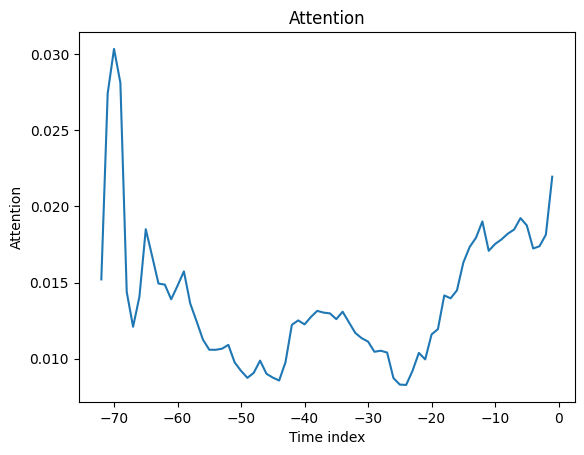

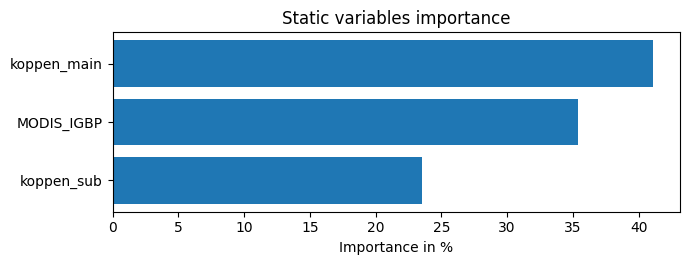

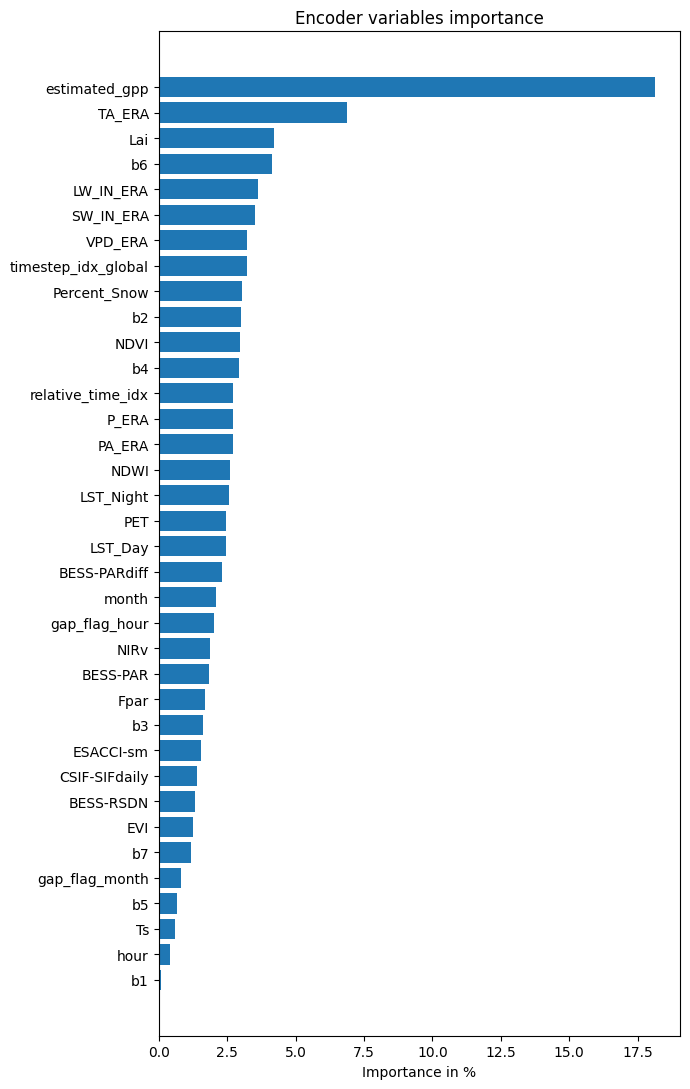

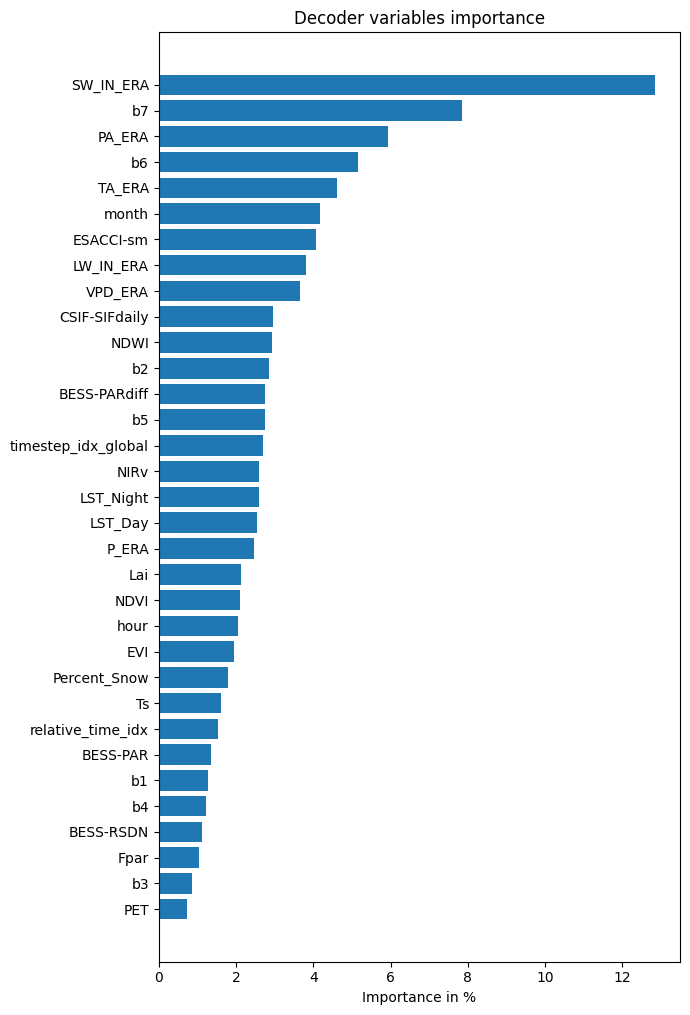

In [17]:
interpretation = best_tft.interpret_output(val_r_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

## Look into encoder variables

In [9]:
len(val_df)-ENCODER_LEN

2736

In [10]:
print(f"time_varying_categoricals_encoder: {len(best_tft.hparams.time_varying_categoricals_encoder)}")
print(f"time_varying_categoricals_decoder: {len(best_tft.hparams.time_varying_categoricals_decoder)}")
print(f"time_varying_reals_encoder: {len(best_tft.hparams.time_varying_reals_encoder)}")
print(f"time_varying_reals_decoder: {len(best_tft.hparams.time_varying_reals_decoder)}")

time_varying_categoricals_encoder: 4
time_varying_categoricals_decoder: 2
time_varying_reals_encoder: 32
time_varying_reals_decoder: 31


In [11]:
val_r_predictions.keys()

('prediction',
 'encoder_attention',
 'decoder_attention',
 'static_variables',
 'encoder_variables',
 'decoder_variables',
 'decoder_lengths',
 'encoder_lengths')

In [12]:
# From https://pytorch-forecasting.readthedocs.io/en/stable/_modules/pytorch_forecasting/models/temporal_fusion_transformer.html#TemporalFusionTransformer
# and https://github.com/jdb78/pytorch-forecasting/blob/50d38acebf4a68b77a7fba29b57fe84045e06f35/pytorch_forecasting/models/temporal_fusion_transformer/sub_modules.py#L324
# Variable importanat generated based on encoder_input_sizes (Defined below)
encoder_input_sizes = {
            name: best_tft.input_embeddings.output_size[name] for name in best_tft.hparams.time_varying_categoricals_encoder
        }
encoder_input_sizes.update(
            {
                name: best_tft.hparams.hidden_continuous_sizes.get(name, best_tft.hparams.hidden_continuous_size)
                for name in best_tft.hparams.time_varying_reals_encoder
            }
        )
print(encoder_input_sizes.keys())

dict_keys(['month', 'hour', 'gap_flag_month', 'gap_flag_hour', 'timestep_idx_global', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day', 'LST_Night', 'relative_time_idx', 'estimated_gpp'])


In [13]:
print(f"time_varying_reals_encoder({len(best_tft.hparams.time_varying_reals_encoder)}):{best_tft.hparams.time_varying_reals_encoder}")
print(f"encoder_variables({len(best_tft.encoder_variables)}):         {best_tft.encoder_variables}")

time_varying_reals_encoder(32):['timestep_idx_global', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day', 'LST_Night', 'relative_time_idx', 'estimated_gpp']
encoder_variables(36):         ['month', 'hour', 'gap_flag_month', 'gap_flag_hour', 'timestep_idx_global', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day', 'LST_Night', 'relative_time_idx', 'estimated_gpp']


In [83]:
# Attempt to get total virable importance
print(val_r_predictions['encoder_variables'].shape)
encoder_variables = val_r_predictions['encoder_variables'].squeeze(-2)
print(encoder_variables.shape)

# from https://github.com/jdb78/pytorch-forecasting/blob/1a8683f66a65f5f7e59fd794229e6b3cbc0d47bf/pytorch_forecasting/utils.py#L121
encode_mask = torch.arange(encoder_variables.size(1), device=val_r_predictions['encoder_lengths'].device).unsqueeze(0) >= val_r_predictions['encoder_lengths'].unsqueeze(-1)
print(encode_mask.shape)
encoder_variables = encoder_variables.masked_fill(encode_mask.unsqueeze(-1), 0.0).sum(dim=1)
print(f"{encoder_variables.shape}:\n{encoder_variables[:2]}")
total = val_r_predictions["encoder_lengths"].where(val_r_predictions["encoder_lengths"] > 0, torch.ones_like(val_r_predictions["encoder_lengths"])).unsqueeze(-1)
print(total.shape)
print((encoder_variables[:,35:36]).shape)
month_weights = (encoder_variables[:,35:36]/total).sum(dim=0)
print(month_weights)
print(best_tft.encoder_variables[35:36])
100*month_weights/interpretation['encoder_variables'].sum(-1).unsqueeze(-1)

torch.Size([936, 72, 1, 36])
torch.Size([936, 72, 36])
torch.Size([936, 72])
torch.Size([936, 36]):
tensor([[3.7672, 0.1405, 0.4264, 1.0099, 0.9936, 2.8239, 3.3842, 3.4229, 2.6822,
         1.9139, 1.2918, 1.2455, 3.7949, 0.6915, 0.0614, 2.5719, 1.6452, 2.5150,
         0.2532, 1.3633, 0.5314, 1.4964, 1.4764, 1.7364, 0.5995, 2.2094, 3.5362,
         2.3497, 1.3499, 2.2943, 1.8804, 1.4344, 1.7503, 3.2059, 2.1140, 8.0369],
        [3.7670, 0.1416, 0.4182, 1.0138, 0.9965, 2.8182, 3.3915, 3.4414, 2.6837,
         1.9145, 1.2783, 1.2458, 3.7985, 0.6937, 0.0614, 2.5734, 1.6460, 2.5320,
         0.2534, 1.3417, 0.5319, 1.4924, 1.4881, 1.7365, 0.6004, 2.2104, 3.5211,
         2.3500, 1.3535, 2.2944, 1.8770, 1.4294, 1.7524, 3.2014, 2.1124, 8.0380]])
torch.Size([936, 1])
torch.Size([936, 1])
tensor([169.8097])
['estimated_gpp']


tensor([18.1421])

In [15]:
for i, x in enumerate(val_r_predictions['encoder_variables']):
  if i> 2:
     break
  
  for e, y in enumerate(x):
    print(f'{e}.({len(y[0])}):{y[0].tolist()}')
  print()

0.(36):[0.0488799549639225, 0.0009182168287225068, 0.012845692224800587, 0.00774590577930212, 0.00923440046608448, 0.04783171787858009, 0.04070771858096123, 0.04340338334441185, 0.036038484424352646, 0.027574334293603897, 0.036510080099105835, 0.01669415645301342, 0.04397143796086311, 0.007142158690840006, 0.000662144273519516, 0.034020766615867615, 0.019716091454029083, 0.03264801576733589, 0.0032232857774943113, 0.03167855739593506, 0.010915389284491539, 0.020486338064074516, 0.015869319438934326, 0.023206932470202446, 0.005550500936806202, 0.03032984584569931, 0.028162606060504913, 0.03541359305381775, 0.030601153150200844, 0.024701785296201706, 0.017560049891471863, 0.03108474798500538, 0.020857417955994606, 0.05869963765144348, 0.03422658517956734, 0.11088762432336807]
1.(36):[0.0488862618803978, 0.0009991922415792942, 0.006554612889885902, 0.008561069145798683, 0.00942265521734953, 0.047818537801504135, 0.040789779275655746, 0.04188799485564232, 0.03610026463866234, 0.02768958732

In [22]:
print(f"decoder_variables({len(best_tft.decoder_variables)}): {best_tft.decoder_variables}")
for i, x in enumerate(val_r_predictions['decoder_variables']):
  if i> 2:
     break
  
  for e, y in enumerate(x):
    print(f'{e}.({len(y[0])}):{y[0].tolist()}')

decoder_variables(33): ['month', 'hour', 'timestep_idx_global', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day', 'LST_Night', 'relative_time_idx']
0.(33):[0.005955849774181843, 0.03141260892152786, 0.00556391105055809, 0.07364650070667267, 0.16910995543003082, 0.04340800270438194, 0.038595058023929596, 0.03315826505422592, 0.018794797360897064, 0.02743840403854847, 0.011623675934970379, 0.03601842373609543, 0.014726094901561737, 0.03885256126523018, 0.003164582420140505, 0.010814903303980827, 0.018538685515522957, 0.04665696248412132, 0.07477716356515884, 0.0025723432190716267, 0.04653672128915787, 0.009049547836184502, 0.027649270370602608, 0.007483504246920347, 0.012783225625753403, 0.034505799412727356, 0.0266974288970232, 0.02076810412108898, 0.002602796768769622, 0.026